<a href="https://colab.research.google.com/github/adgregory/adsmovil/blob/main/CTR_Prueba_Tecnica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# State of the Art

1. Deep Interest Network for Click-Through Rate Prediction
https://sci-hub.hkvisa.net/10.1145/3219819.3219823

Features y modelos implementados

2. DataSet de Kaggle. Features implementados.
https://www.kaggle.com/c/avazu-ctr-prediction/overview

# Install required libraries

In [3]:
%%capture
!pip install tensorflow_data_validation

# Libraries

In [283]:
# General
import pandas as pd
import numpy as np
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_data_validation as tfdv

In [138]:
sns.set_theme()

# Data Visualization

## Data Visualization Helper Functions

In [193]:
def plot_feature_histogram(tfdv_stats, ft_idx):

  hist_df = pd.DataFrame(columns=['name', 'frequency'])
  for value in tfdv_stats.datasets[0].features[ft_idx].string_stats.top_values:
    hist_df = hist_df.append({'name': value.value, 'frequency': value.frequency}, ignore_index = True)

  # Graficar Feature Histogram
  ft_name = ctr_stats.datasets[0].features[ft_idx].path.step[0]
  sns.histplot(hist_df, x = 'name', y = 'frequency')
  plt.title(ft_name + ' feature histogram')
  plt.xticks(rotation=90)


## Data Understanding

In [353]:
ctr_df = pd.read_csv('Base_proyecto.csv')
ctr_df.head()

,id,ad_position,ad_size,hour_of_day_utc,inventory_source,platform_bandwidth,environment_type,platform_carrier,app_bundle,domain,clicks,impressions,ctr
0,1,FULLSCREEN,320x480,21,UNITY,WIFI,APP,-1,Other,UNKNOWN,6,29,0.206897
1,2,FULLSCREEN,320x480,23,UNITY,WIFI,APP,-1,com.wordgame.puzzle.board.es,UNKNOWN,13,86,0.151163
2,3,0,320x480,23,OPERA_MEDIA,CELL_3G,APP,Claro,com.jamendoandoutly.mainpakkage,UNKNOWN,0,11,0.000000
3,4,FULLSCREEN,320x480,23,MOPUB,CELL_4G,APP,Movistar,com.drilens.wamr,UNKNOWN,0,38,0.000000
4,5,0,320x480,5,OPERA_MEDIA,WIFI,APP,Movistar,com.jam.endo,UNKNOWN,0,19,0.000000


Teniendo en cuenta las columnas de 'clicks' e 'impressions', se realiza el calculo de 'ctr' y se corrobora que los valores dados de ctr (con precision de 16 decimales) concurden con la división establecida.

In [331]:
filtered_df = pd.DataFrame()
filtered_df['clicks'] = ctr_df['clicks']
filtered_df['impressions'] = ctr_df['impressions']

filtered_df['ctr_calculated'] = np.round(np.float64(filtered_df['clicks']/filtered_df['impressions']), 16)

In [327]:
filtered_df['comparision'] = list(filtered_df['ctr_calculated'] == ctr_df['ctr'])

In [330]:
filtered_df[filtered_df['comparision'] == False]

,clicks,impressions,ctr_calculated,comparision
11,2,65,0.030769,False
17,1,18,0.055556,False
18,3,287,0.010453,False
20,3,14,0.214286,False
33,4,110,0.036364,False
...,...,...,...,...
30712,3,7,0.428571,False
30772,3,7,0.428571,False
30871,3,7,0.428571,False
30898,3,7,0.428571,False


Dado que la formula de CTR = clicks/impressions, nuestro modelo no puede utiliar estos features como entradas.

In [15]:
ctr_df.drop(columns = ['id', 'clicks', 'impressions'], inplace = True)

In [17]:
ctr_df.head()

,ad_position,ad_size,hour_of_day_utc,inventory_source,platform_bandwidth,environment_type,platform_carrier,app_bundle,domain,ctr
0,FULLSCREEN,320x480,21,UNITY,WIFI,APP,-1,Other,UNKNOWN,0.206897
1,FULLSCREEN,320x480,23,UNITY,WIFI,APP,-1,com.wordgame.puzzle.board.es,UNKNOWN,0.151163
2,0,320x480,23,OPERA_MEDIA,CELL_3G,APP,Claro,com.jamendoandoutly.mainpakkage,UNKNOWN,0.000000
3,FULLSCREEN,320x480,23,MOPUB,CELL_4G,APP,Movistar,com.drilens.wamr,UNKNOWN,0.000000
4,0,320x480,5,OPERA_MEDIA,WIFI,APP,Movistar,com.jam.endo,UNKNOWN,0.000000


In [19]:
ctr_stats = tfdv.generate_statistics_from_dataframe(ctr_df)

# Visualization of Raw Data
tfdv.visualize_statistics(ctr_stats)

In [21]:
# Schema
ctr_schema = tfdv.infer_schema(statistics=ctr_stats)
tfdv.display_schema(ctr_schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'ad_position',STRING,required,,'ad_position'
'ad_size',STRING,required,,'ad_size'
'hour_of_day_utc',INT,required,,-
'inventory_source',STRING,required,,'inventory_source'
'platform_bandwidth',STRING,required,,'platform_bandwidth'
'environment_type',STRING,required,,'environment_type'
'platform_carrier',STRING,required,,'platform_carrier'
'app_bundle',STRING,required,,'app_bundle'
'domain',STRING,required,,'domain'


,Values
Domain,
'ad_position',"'0', 'ABOVE_THE_FOLD', 'BELOW_THE_FOLD', 'FOOTER', 'FULLSCREEN', 'HEADER', 'POSITION_UNKNOWN'"
'ad_size',"'-1x-1', '160x600', '1x1', '250x250', '256x192', '300x100', '300x250', '300x480', '300x50', '300x600', '320x100', '320x480', '320x50', '320x568', '320x570', '336x280', '360x56', '360x592', '360x598', '360x640', '360x703', '370x58', '375x667', '400x824', '411x64', '412x790', '412x814', '414x736', '424x808', '480x320', '728x90', '768x1024'"
'inventory_source',"'APPNEXUS', 'CRITEO', 'GOOGLE_ADX', 'INMOBI', 'INNERACTIVE', 'MILLENNIAL', 'MOPUB', 'OPENX', 'OPERA_MEDIA', 'RICHAUDIENCE', 'RUBICON', 'SMARTADSERVER', 'TRIPLELIFT', 'UNITY', 'UNRULYX', 'VERVE'"
'platform_bandwidth',"'CELL_2G', 'CELL_3G', 'CELL_4G', 'CELL_UNKNOWN', 'CONNECTION_UNKNOWN', 'ETHERNET', 'UNKNOWN', 'WIFI'"
'environment_type',"'APP', 'UNKNOWN', 'WEB'"
'platform_carrier',"'-1', 'Avantel ', 'Claro', 'Movistar', 'Tigo'"
'app_bundle',"'1524620009', '1533452966', 'Other', 'UNKNOWN', 'air.com.aceviral.motox3m', 'air.com.jogatina.domino.android', 'aplicaciones.paleta.alterlegionanime', 'aplicaciones.paleta.legionanimeday', 'aplicaciones.paleta.legionanimefull', 'aplicaciones.paleta.legionanimexs', 'bubble.shooter.shooting.shoot.game', 'cjvg.santabiblia', 'cn.wps.moffice_eng', 'coloring.color.number.happy.paint.art.drawing.puzzle', 'com.LoopGames.Domino', 'com.TeryBit.TeryBit', 'com.app.romansl.skvishy', 'com.bigcool.puzzle.fruitgenies', 'com.callapp.contacts', 'com.cyberlink.youcammakeup', 'com.cyberlink.youperfect', 'com.digitalproshare.filmapp', 'com.dogs.nine', 'com.drilens.wamr', 'com.dropdom.blockpuzzle.hwwgame', 'com.dualspace.multispace.android', 'com.dvex.movp', 'com.filmlegacy.slupaf', 'com.finecameffect.fortyfunseven', 'com.firsttouchgames.dls7', 'com.firsttouchgames.hero2', 'com.firsttouchgames.smp', 'com.fugo.wow', 'com.fungameplus.smartrope', 'com.gameeapp.android.app', 'com.gammalab.chessopenings', 'com.hafert.ImposterAssassin', 'com.higgs.cubemaster3d', 'com.jam.endo', 'com.jamendoandoutly.mainpakkage', 'com.linkdesks.iBubble', 'com.ludashi.dualspace', 'com.mars.avgchapters', 'com.merge.cat.paradise', 'com.merge.cube.winner', 'com.mintgames.triplecrush.tile.fun', 'com.mobz.vd.in', 'com.mojang.minecraftvr', 'com.movinapp.dict.frde.free', 'com.movinapp.dict.french.free', 'com.movinapp.dict.frit.free', 'com.movinapp.facts.science', 'com.musicops.vanillamusicdownload', 'com.musicplayer.playermusic', 'com.olx.olx', 'com.rahul.videoderbeta', 'com.sanhe.clipclaps', 'com.snowcorp.stickerly.android', 'com.solitaire.spider.patience.ocean.aquarium', 'com.sukhavati.gotoplaying.bubble.BubbleShooter.mint', 'com.superbox.aos.fire2048', 'com.sweetfuirt.candy', 'com.tilemaster.puzzle.block.match', 'com.tripledot.woodoku', 'com.vs.bhaktiringtone', 'com.wordgame.puzzle.board.es', 'com.wordgame.puzzle.resort.story', 'com.zareklamy', 'el.tio', 'fast.phone.clean', 'fluffyslime.swoimi.rukami', 'futbol.play', 'games.spearmint.matchanimal', 'games.spearmint.triplecrush', 'link.merge.puzzle.onnect.number', 'mobi.mangatoon.comics.aphone.spanish', 'mobi.mangatoon.novel.portuguese', 'mod.craftgame.minigame', 'music.musicplayer', 'org.majestic.congratulation', 'phone.cleaner.speed.booster.cache.clean.android.master', 'tm.alarm.clock', 'tv.mxliptv.app', 'video.downloaderforinstagram.photodownloader.repost', 'videoeditor.videorecorder.screenrecorder', 'vmd.windowphotoeditor'"
'domain',"'Other', 'UNKNOWN', 'absolutelyconnected.com', 'ahoramismo.com', 'aminoapps.com', 'ask.fm', 'autogestionatusalud.com', 'b612.snow.me', 'bbc.com', 'bebesymas.com', 'bible.knowing-jesus.com', 'biggestchef.com', 'bigglobaltravel.com', 'callapp.com', 'cleverclassic.com', 'comedy.com', 'consejosytrucos.co', 'daquan.tv', 'dff3a14dc.app-ads-txt.com', 'docjournals.com', 'doctoreport.com', 'drama.fandom.com', 'drivepedia.com', 'easybrain.com', 'economipedia.com', 'elmundo.es', 'fandom.com', 'fifaindex.com', 'fortnitetracker.com', 'gameofglam.com', 'gardenmanage.com', 'gingerize.c

Teniendo en cuenta a la vizualizacion de los datos unicos categoricos presentes en el dataset, se presta atención principal a los siguientes features:



*   **platform_carrier**: Platform carrier cuenta con 5 posibles valores, entre los cuales existe el '-1', el cual corresponde a la inexistencia del dato en el dataset. Este valor corresponde al 51.7% del total de datos. Por lo tanto, la probabilidad de que el siguiente dato en producción sea desconocido es más alta, que conociendo alguna de las otras 4 carriers presentadas (Avantel, Claro, Movistar Tigo)

*   **app_bundle**: De igual forma, este feature cuenta con valores desconocidos que representan el ~71%
*   **domain** ~90%


Analisis de platform_carrier

In [221]:
platform_carrier_unique_val = len(ctr_schema.string_domain[5].value)
print('Valores unicos de {}: {}'.format(ctr_schema.string_domain[5].name, platform_carrier_unique_val))

Valores unicos de platform_carrier: 5


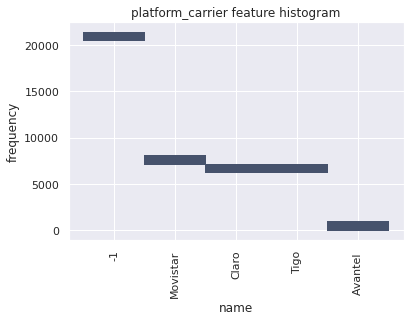

In [223]:
plot_feature_histogram(ctr_stats, ft_idx = 6)

Analisis de **app_bundle**

In [218]:
app_bundle_unique_val = len(ctr_schema.string_domain[6].value)
print('Valores unicos de {}: {}'.format(ctr_schema.string_domain[6].name, app_bundle_unique_val))

Valores unicos de app_bundle: 86


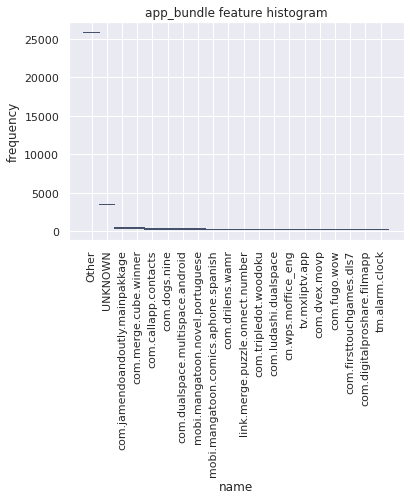

In [219]:
plot_feature_histogram(ctr_stats, ft_idx = 7)

Analisis de **domain**

In [214]:
domain_unique_val = len(ctr_schema.string_domain[7].value)
print('Valores unicos de {}: {}'.format(ctr_schema.string_domain[7].name,domain_unique_val))

Valores unicos de domain: 94


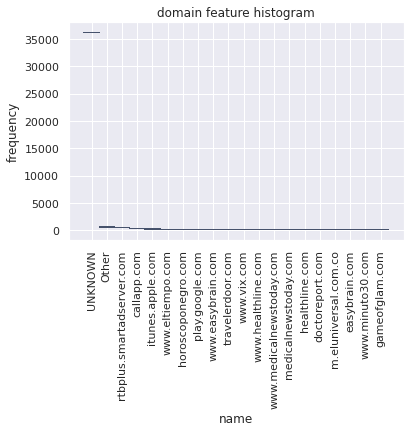

In [215]:
plot_feature_histogram(ctr_stats, ft_idx = 8)

In [ ]:
def delete_unknown_from_list(df, unknown_list):
  


Teniendo en cuenta los argumentos presentados, se eliminan los features: 'plaform_carrier’, 'app_bundle', 'domain'.

In [354]:
# ctr_df = ctr_df[ctr_df['platform_carrier'] != '-1']

# ctr_df = ctr_df[ctr_df['app_bundle'] != 'Other']
# ctr_df = ctr_df[ctr_df['app_bundle'] != 'UNKNOWN']

# ctr_df = ctr_df[ctr_df['domain'] != 'UNKNOWN']
# ctr_df = ctr_df[ctr_df['domain'] != 'Other']


# Las que se mantienen
ctr_df = ctr_df[ctr_df['ad_size'] != '-1x-1']
ctr_df = ctr_df[ctr_df['ad_size'] != '1x1']

ctr_df = ctr_df[ctr_df['ad_position'] != 'POSITION_UNKNOWN']
ctr_df = ctr_df[ctr_df['ad_position'] != '0']

ctr_df = ctr_df[ctr_df['platform_bandwidth'] != 'CONNECTION_UNKNOWN']
ctr_df = ctr_df[ctr_df['platform_bandwidth'] != 'CELL_UNKNOWN']
ctr_df = ctr_df[ctr_df['platform_bandwidth'] != 'UNKNOWN']

ctr_df = ctr_df[ctr_df['environment_type'] != 'UNKNOWN']

In [34]:
to_use = ['ad_position, ad_size, ‘inventory_source’, ‘platform_bandwidth’,  ‘environment_type’, ']

to_remove = ['plaform_carrier’, ‘app_bundle’, ‘domain’']

In [355]:
ctr_df

,id,ad_position,ad_size,hour_of_day_utc,inventory_source,platform_bandwidth,environment_type,platform_carrier,app_bundle,domain,clicks,impressions,ctr
0,1,FULLSCREEN,320x480,21,UNITY,WIFI,APP,-1,Other,UNKNOWN,6,29,0.206897
1,2,FULLSCREEN,320x480,23,UNITY,WIFI,APP,-1,com.wordgame.puzzle.board.es,UNKNOWN,13,86,0.151163
3,4,FULLSCREEN,320x480,23,MOPUB,CELL_4G,APP,Movistar,com.drilens.wamr,UNKNOWN,0,38,0.000000
5,6,FULLSCREEN,320x480,8,UNITY,WIFI,APP,-1,Other,UNKNOWN,2,42,0.047619
6,7,FULLSCREEN,480x320,9,UNITY,WIFI,APP,-1,Other,UNKNOWN,0,24,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41345,193139,ABOVE_THE_FOLD,320x50,18,MOPUB,CELL_4G,APP,Claro,Other,UNKNOWN,1,1,1.000000
41347,193412,ABOVE_THE_FOLD,320x50,7,MOPUB,WIFI,APP,-1,Other,UNKNOWN,1,1,1.000000
41348,193447,FULLSCREEN,320x480,13,MOPUB,WIFI,APP,-1,com.jam.endo,UNKNOWN,1,1,1.000000
41349,193455,FULLSCREEN,320x480,10,MOPUB,CELL_4G,APP,Movistar,Other,UNKNOWN,1,1,1.000000


# Feature Importance

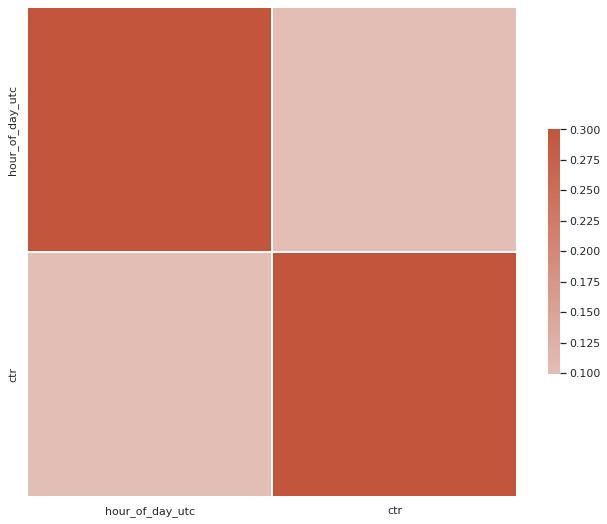

In [31]:
sns.set_theme(style="white")

model_corr = ctr_df.corr()

f, ax = plt.subplots(figsize=(11, 9))
#mask = np.triu(np.ones_like(model_corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(model_corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})